In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

GEREKLİ KÜTÜPHANELER

In [ ]:
import torch
import torch.nn.functional as F # Aktivasyon fonksiyonları için.
from torch_geometric.datasets import Planetoid # Cora veri setini yükleyebilmek için. *1- Planetoid genellikle birden fazla alt grafik içerir...
from torch_geometric.nn import GCNConv # Grafik konvolüsyon katmanı.
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx

1- Cora veri setini yüklüyoruz.

In [ ]:
dataset = Planetoid(root ='data', name ='Cora')
data = dataset[0] # *1- ... ancak, Cora veri seti yalnızca tek bir grafik içerir, bu yüzden 0. indexi aldık.
# Cora veri seti, PyTorch Geometric’in Planetoid sınıfı üzerinden yüklendiğinde, zaten normalize edilmiş olarak geldiği için ekstra bir normalize etme işlemi gerekmez.

2- GCN modeli tanımlaması.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim): # input(giriş), hidden(gizli), output(çıkış) katmanlarının düğüm özelliklerinin boyutu.
        super(GCN, self).__init__() # modelin temel işlevselliğini (örneğin, parametrelerin yönetimi, modelin eğitimi ve değerlendirilmesi gibi) sağlar.
        self.conv1 = GCNConv(input_dim, hidden_dim) # ilk GCN katmanı
        self.conv2 = GCNConv(hidden_dim, output_dim) # ikinci GCN katmanı

    def forward(self, x, edge_index): # Forward metodu, modelin giriş verilerini alır ve bu veriler üzerinde işlem yaparak çıktıyı üretir. Modelin katmanlarını ve bu katmanlar arasındaki bağlantıları tanımlar.
        x = self.conv1(x, edge_index) #İlk GCN katmanı, düğüm özelliklerini güncelliyoruz.
        x = F.relu(x) #Negatif değerleri sıfıra çevirir ve pozitif değerleri olduğu gibi bırakır.
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim = 1)
        # Softmax, bir dizi sayıyı alır ve
        # bu sayıları 0 ile 1 arasında normalize ederek bir olasılık dağılımı oluşturur. Her bir çıkış değeri, toplam çıkışların toplamına bölünerek hesaplanır.
        # log_softmax kullanmak, kayıp hesaplamasını daha verimli hale getirir.

3- Modelin başlatılması.

In [ ]:
model = GCN(input_dim = dataset.num_node_features, hidden_dim = 16, output_dim = dataset.num_classes)
# dataset.num_node_features, veri setindeki düğümlerin özellik sayısını belirtir. Modelin giriş katmanında kullanılacak olan özelliklerin boyutunu tanımlar.
# Hidden, modelin öğrenme kapasitesini etkileyen bir parametredir.
# Output, modelin çıktısı, her bir düğüm için hangi sınıfa ait olduğunu belirlemek için kullanılacaktır.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# model.parameters, modelin öğrenilebilir parametrelerini döndürür.
# lr=0.01, öğrenme hızını belirtir.
# weight_decay=5e-4, overfitting i önlemek için.

4- Modelin, eğitim verisi ile eğitilmesi.

In [ ]:
train_losses = []
val_losses = []
accuracies = []
f1_scores = []
best_val_acc, best_model = 0, None
def train():
    model.train()
    optimizer.zero_grad()
    # optimizer.zero_grad, optimizasyon algoritmasının gradyanlarını sıfırlar.
    # PyTorch, her backward() çağrısında gradyanları toplar, bu nedenle önceki gradyanların etkisini kaldırmak için sıfırlanması gerekir.
    out = model(data.x, data.edge_index)
    # out = model(data.x, data.edge_index),forward metodunu çağırarak, giriş verilerini kullanarak modelin çıktısını hesaplar.
    train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) # loss = F.nll_loss(...), modelin çıktısı ile gerçek etiketler arasındaki kaybı hesaplar.
    # train_mask, eğitim verisi için.
    train_loss.backward()
    optimizer.step()
    # optimizer.step(), modelin öğrenme sürecinde hesaplanan gradyanları kullanarak modelin ağırlıklarını günceller. Modelin parametrelerinin optimize edilmesi için gereklidir.
    model.eval()
    with torch.no_grad():
        val_out = model(data.x, data.edge_index) # Doğrulama verileri üzerinde tahminler yapar.
        val_loss = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])

    train_losses.append(train_loss.item()) # train_loss.item() ifadesi, PyTorch tensorunu bir Python sayısına dönüştürür, eğitim kayıplarını takip etmek için kullanılır.
    val_losses.append(val_loss.item())

5- Modelin test edilmesi.

In [ ]:
def evaluate(mask):
    model.eval() # Modelin test verileri üzerinde daha doğru sonuçlar vermesini sağlar.
    with torch.no_grad():
     out = model(data.x, data.edge_index)
     pred = out.argmax(dim = 1) # En yüksek olasılığa sahip sınıfı seçer.
     acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
     f1 = f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(), average = 'weighted') # average='weighted', her sınıfın F1 skorunu, o sınıfın örnek sayısına göre ağırlıklandırarak hesaplar.
    return acc, f1

6- Eğitim döngüsü.

In [ ]:
for epoch in range(200):
    train()
    if epoch % 10 == 0:
        train_acc, train_f1 = evaluate(data.train_mask)
        val_acc, val_f1 = evaluate(data.val_mask)
        test_acc, test_f1 = evaluate(data.test_mask)

        accuracies.append(test_acc)
        f1_scores.append(test_f1)

        print(f'Epoch {epoch} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}')


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict().copy() # Modelin ağırlıkları kaydedilir. state_dict() metodu,
            # modelin tüm öğrenilebilir parametrelerini içeren bir sözlük döndürür. copy() metodu,
            # bu sözlüğün bir kopyasını alır. Modelin en iyi performans gösterdiği durumu saklamak için önemlidir.
            # ---
            # if.. i yapmaktaki amacımız, aşırı öğrenmeyi önleme, tekrar kullanılabilirlik ve modelin en iyi versiyonunu kullanmak.

Epoch 0 | Train Acc: 0.2410 | Val Acc: 0.2410 | Test Acc: 0.2410
Epoch 10 | Train Acc: 0.6240 | Val Acc: 0.6240 | Test Acc: 0.6240
Epoch 20 | Train Acc: 0.7940 | Val Acc: 0.7940 | Test Acc: 0.7940
Epoch 30 | Train Acc: 0.7840 | Val Acc: 0.7840 | Test Acc: 0.7840
Epoch 40 | Train Acc: 0.7820 | Val Acc: 0.7820 | Test Acc: 0.7820
Epoch 50 | Train Acc: 0.7940 | Val Acc: 0.7940 | Test Acc: 0.7940
Epoch 60 | Train Acc: 0.7950 | Val Acc: 0.7950 | Test Acc: 0.7950
Epoch 70 | Train Acc: 0.7940 | Val Acc: 0.7940 | Test Acc: 0.7940
Epoch 80 | Train Acc: 0.7970 | Val Acc: 0.7970 | Test Acc: 0.7970
Epoch 90 | Train Acc: 0.7990 | Val Acc: 0.7990 | Test Acc: 0.7990
Epoch 100 | Train Acc: 0.7990 | Val Acc: 0.7990 | Test Acc: 0.7990
Epoch 110 | Train Acc: 0.8010 | Val Acc: 0.8010 | Test Acc: 0.8010
Epoch 120 | Train Acc: 0.8040 | Val Acc: 0.8040 | Test Acc: 0.8040
Epoch 130 | Train Acc: 0.8050 | Val Acc: 0.8050 | Test Acc: 0.8050
Epoch 140 | Train Acc: 0.8050 | Val Acc: 0.8050 | Test Acc: 0.8050
Epoch 

In [ ]:
model.load_state_dict(best_model) # Daha önce kaydedilmiş olan en iyi modelin ağırlıklarını mevcut modelin ağırlıklarıyla değiştirmek için.

<All keys matched successfully>

7- Loss, accuracy ve F1 score grafiği

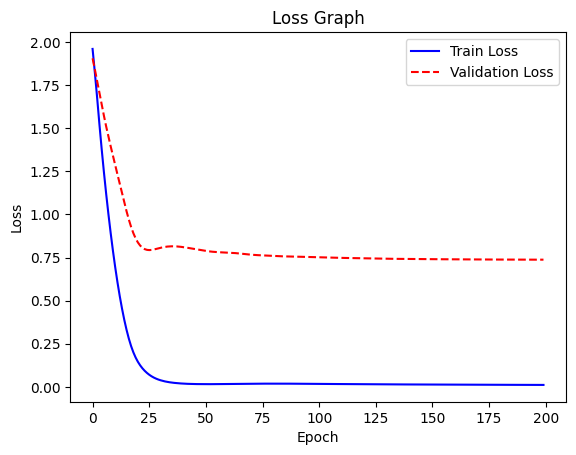

In [ ]:
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red", linestyle="dashed")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

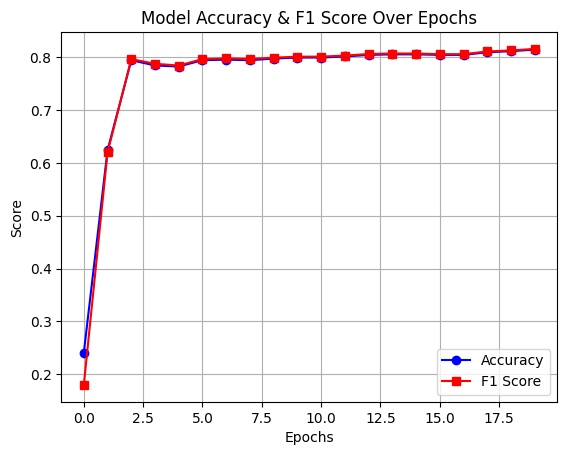

In [ ]:
plt.plot(accuracies, marker='o', label='Accuracy', color='b')
plt.plot(f1_scores, marker='s', label='F1 Score', color='r')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Model Accuracy & F1 Score Over Epochs')
plt.legend()
plt.grid()
plt.show()

8- Model Performansı

In [ ]:
final_acc, final_f1 = evaluate(data.test_mask)
print(f'Final Accuracy: {final_acc:.4f}, Final F1 Score: {final_f1:.4f}')

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    final_pred = out.argmax(dim = 1)

print("\nTahmin Edilen Etiketler:", final_pred[data.test_mask].cpu().numpy())
print("Gerçek Etiketler:", data.y[data.test_mask].cpu().numpy())

Final Accuracy: 0.8130, Final F1 Score: 0.8143

Tahmin Edilen Etiketler: [1 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 1 2 1 2 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 4 1 1 1 1 1 1 5 5 4 4 4 1 1 1 1 1 1 6 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 5 5 5 5 5 5 2 2 2 2 2 6 6 3 0 0 0 0 5 0 0 0 3 0 0 6 0 6 3 3 3 3
 1 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 1 0 5 5 5 5 5 5 2 2 2 4 4 4 4
 4 3 2 5 5 5 5 6 5 5 5 5 6 4 4 0 3 1 0 0 0 6 6 6 6 6 6 6 0 0 0 0 0 0 0 3 0
 0 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 3 5 5 5 5 5 5 4 4 4
 4 4 4 4 4 6 0 5 6 6 0 5 5 5 0 5 4 4 4 3 3 3 3 3 1 3 3 3 3 3 3 1 3 3 4 4 4
 3 3 3 3 3 3 6 3 0 0 0 0 6 5 5 5 4 0 6 6 5 5 1 3 5 5 6 6 4 4 4 3 3 3 4 4 4
 3 4 4 4 1 1 1 1 0 6 0 0 0 0 0 0 0 2 0 5 5 5 3 3 3 3 3 0 0 0 0 0 0 0 3 3 3
 1 1 1 1 1 2 1 1 1 1 1 1 1 3 1 1 1 1 1 0 0 0 6 6 0 0 0 0 1 1 0 6 6 6 6 2 3
 3 0 3 3 4 4 4 4 4 4 4 4 4 4 4 4 0 6 0 6 6 0 0 3 3 3 3 3 1 1 1 3 3 3 3 2 6
 3 5 5 0 5 6 6 6 6 6 3 3 6 

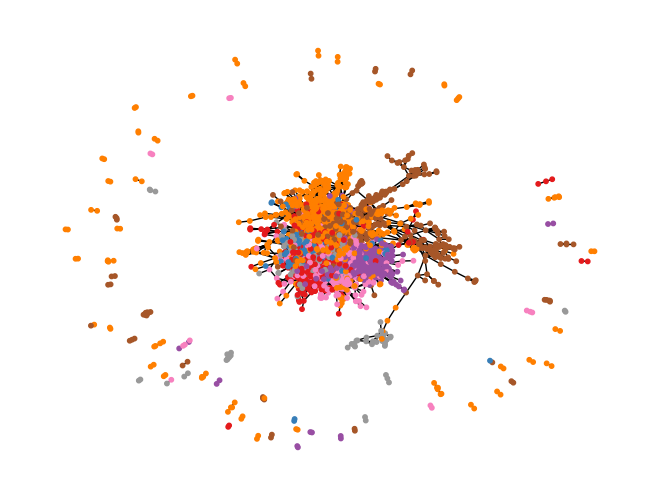

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

def visualize_graph(graph, color):
    nx.draw(graph, with_labels=False, node_color=color, node_size=10, cmap=plt.cm.Set1)
    plt.show()


visualize_graph(G, color=data.y)

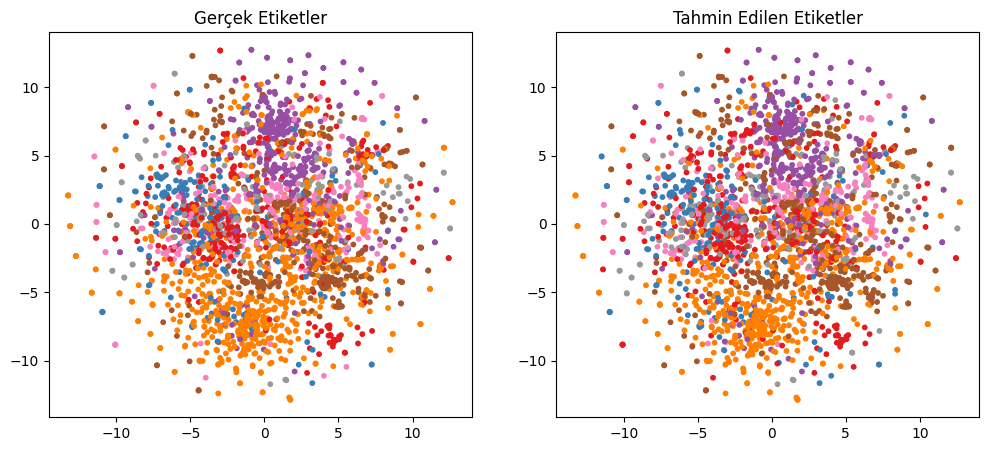

In [ ]:
def visualize_tsne(pred, true_labels):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(data.x.cpu().numpy())

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=true_labels.cpu().numpy(), cmap="Set1", s=10)
    plt.title("Gerçek Etiketler")

    plt.subplot(1, 2, 2)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=pred.cpu().numpy(), cmap="Set1", s=10)
    plt.title("Tahmin Edilen Etiketler")

    plt.show()


visualize_tsne(final_pred, data.y)